In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import cv2
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
# Function to generate image pairs
def generate_image_pairs(images, labels):
    # Generate index for each label
    unique_labels = np.unique(labels)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels) if
                                       label == curr_label])

    # Generate image pairs and labels
    pair_images = []
    pair_labels = []
    for index, image in enumerate(images):
        pos_indices = label_wise_indices.get(labels[index])
        pos_image = images[np.random.choice(pos_indices)]
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        neg_indices = np.where(labels != labels[index])
        neg_image = images[np.random.choice(neg_indices[0])]
        pair_images.append((image, neg_image))
        pair_labels.append(0)

    return np.array(pair_images), np.array(pair_labels)

In [ ]:
!unzip olivetti_faces.npy.zip

Archive:  olivetti_faces.npy.zip
  inflating: olivetti_faces.npy      


In [ ]:
# Get the data directory paths
faces = '/content/olivetti_faces.npy'
faces_targets = '/content/olivetti_faces_target.npy'

In [ ]:
# Load the images and labels
face_images = np.load(faces)
face_labels = np.load(faces_targets)

In [ ]:
target_shape = face_images[0].shape

In [ ]:
images_dataset, labels_dataset = generate_image_pairs(face_images, face_labels)
images_dataset, labels_dataset = shuffle(images_dataset, labels_dataset)

In [ ]:
def visualize(image_pairs, labels, n = 5, title = "Image Pair Examples"):
    """ Visualize a few pairs """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))
    plt.title(title)
    axs = fig.subplots(n, 2)
    for i in range(n):
        show(axs[i, 0], image_pairs[i][0])
        show(axs[i, 1], image_pairs[i][1])

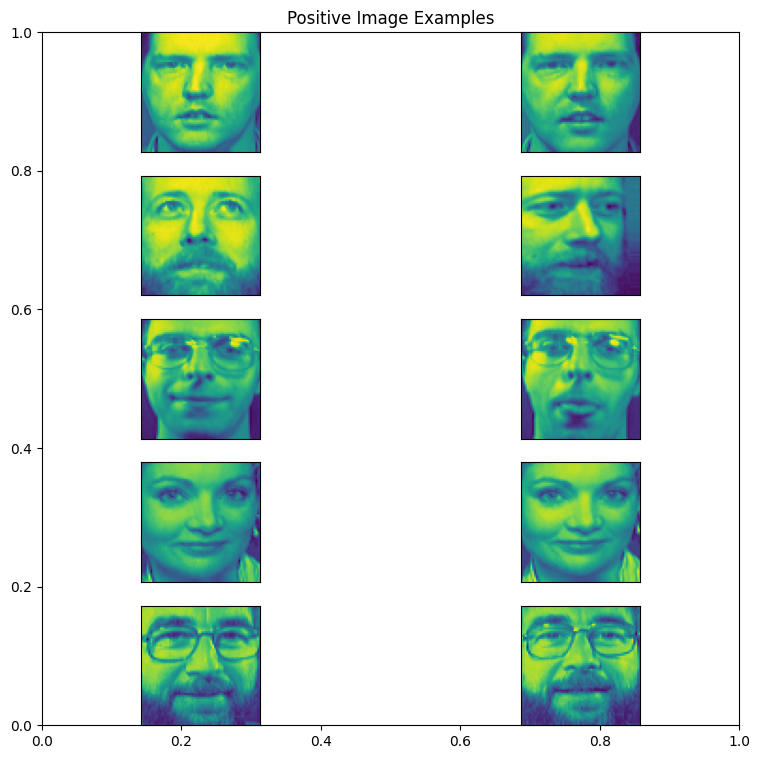

In [ ]:
# Visualize Positive Images
n = 5
indices = np.where(labels_dataset == 1)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Positive Image Examples")

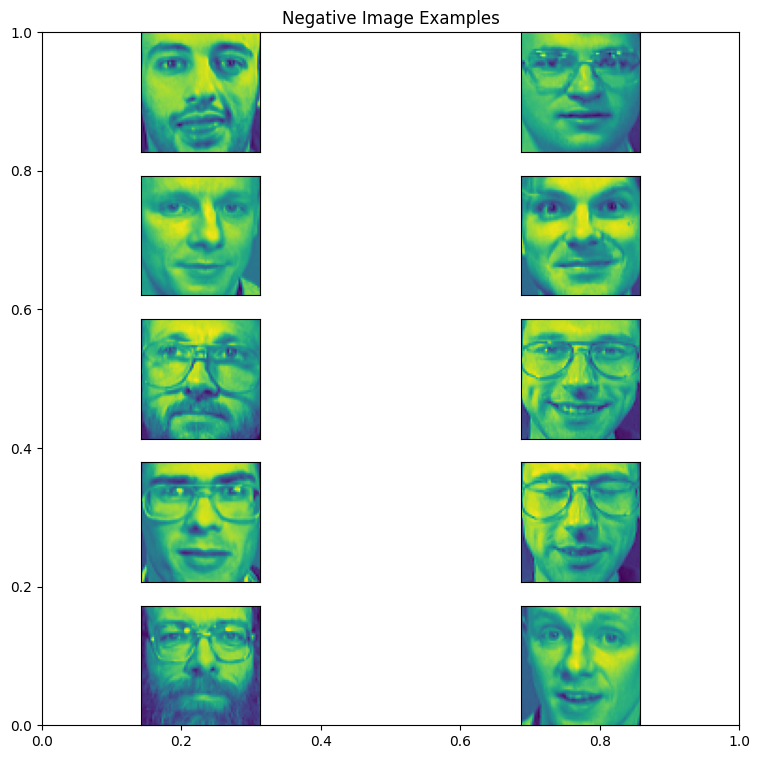

In [ ]:
# Visualize Negative Images
n = 5
indices = np.where(labels_dataset == 0)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Negative Image Examples")


**EMBEDDING**

In [ ]:
inputs = layers.Input((64, 64, 1))

x = layers.Conv2D(64, (10, 10), padding="same", activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (7, 7), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (4, 4), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256, (4, 4), padding="same", activation="relu")(x)
fcOutput = layers.Flatten()(x)
fcOutput = layers.Dense(4096, activation = "relu")(fcOutput)
outputs = layers.Dense(1024, activation = "sigmoid")(fcOutput)

embedding = Model(inputs, outputs, name = "Embedding")

**SIASEME NETWORK**

In [ ]:
import tensorflow.keras.backend as K

In [ ]:
# Define the Contrastive Loss
def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)

    return loss

In [ ]:
# Distance Layer
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance
    between the embeddings
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, compare):
        sum_squared = K.sum(K.square(anchor - compare), axis=1, keepdims=True)
        return K.sqrt(K.maximum(sum_squared, K.epsilon()))

In [ ]:
anchor_input = layers.Input(name="anchor", shape=target_shape + (1,))
compare_input = layers.Input(name="compare", shape=target_shape + (1,))

distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(compare_input),
)

outputs = layers.Dense(1, activation = "sigmoid") (distances)

siamese_model = Model(
    inputs=[anchor_input, compare_input], outputs=outputs
)

**TRAINING**

In [ ]:
siamese_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = siamese_model.fit([images_dataset[:, 0, :], images_dataset[:, 1, :]], labels_dataset,
                            epochs=50, validation_split = 0.2, batch_size = 64)

Epoch 1/50
10/10 [==============================] - 4s 139ms/step - loss: 0.5905 - accuracy: 0.5688 - val_loss: 0.5810 - val_accuracy: 0.6438
Epoch 2/50
10/10 [==============================] - 1s 112ms/step - loss: 0.5827 - accuracy: 0.5672 - val_loss: 0.5622 - val_accuracy: 0.6438
Epoch 3/50
10/10 [==============================] - 1s 113ms/step - loss: 0.5935 - accuracy: 0.5766 - val_loss: 0.5625 - val_accuracy: 0.6625
Epoch 4/50
10/10 [==============================] - 1s 112ms/step - loss: 0.5660 - accuracy: 0.5906 - val_loss: 0.5492 - val_accuracy: 0.6687
Epoch 5/50
10/10 [==============================] - 1s 112ms/step - loss: 0.5743 - accuracy: 0.5844 - val_loss: 0.5574 - val_accuracy: 0.6313
Epoch 6/50
10/10 [==============================] - 1s 116ms/step - loss: 0.5873 - accuracy: 0.6406 - val_loss: 0.5659 - val_accuracy: 0.7625
Epoch 7/50
10/10 [==============================] - 1s 116ms/step - loss: 0.5712 - accuracy: 0.6219 - val_loss: 0.5614 - val_accuracy: 0.7188
Epoch 

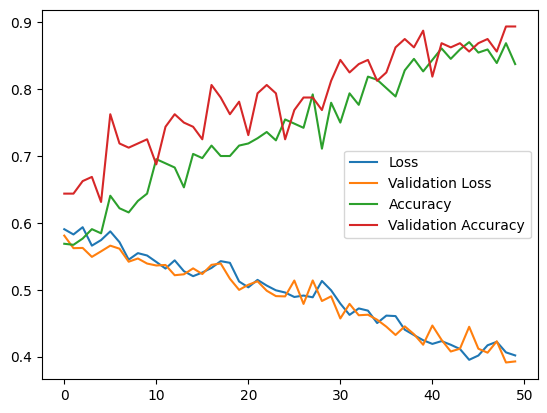

In [ ]:
# Training Plot
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Loss", "Validation Loss", "Accuracy", "Validation Accuracy"])

**TESTING**

In [ ]:
def test_visualize(images, n = 5):
    """ Visualize a few images """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))
    axs = fig.subplots(1, n)
    for i in range(n):
        show(axs[i], images[i])

**TEST1**

In [ ]:
test_indices = [0, 1, 2, 3, 4]
test_index = random.sample(range(10), 1)[0]
test_image = face_images[test_index]

compare_images = []
for i in range(5):
    index = random.sample(range(i * 10, (i + 1) * 10), 1)[0]
    image = face_images[index]
    compare_images.append(image)

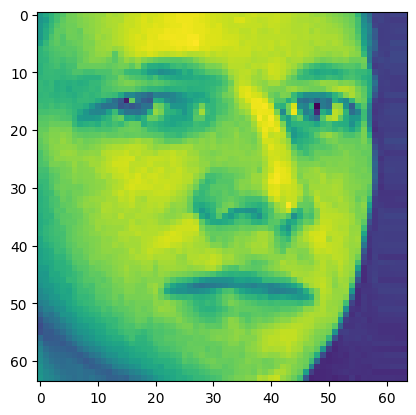

In [ ]:
plt.imshow(test_image)

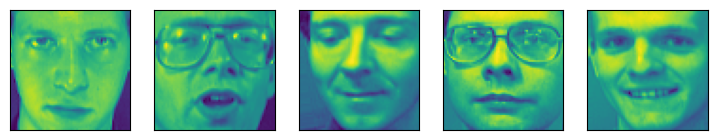

In [ ]:
test_visualize(compare_images)

In [ ]:
image_pairs = []

for image in compare_images:
    image_pairs.append((test_image, image))

image_pairs = np.array(image_pairs)

In [ ]:
score = siamese_model.predict([image_pairs[:, 0, :], image_pairs[:, 1, :]])

1/1 [==============================] - 0s 482ms/step


In [ ]:
print(score)

[[0.5761157 ]
 [0.33606127]
 [0.02796921]
 [0.03386616]
 [0.02083193]]


***TEST 2***

In [ ]:
test_indices = [0, 1, 2, 3, 4]
test_index = random.sample(range(10, 20), 1)[0]
test_image = face_images[test_index]

compare_images = []
for i in range(5):
    index = random.sample(range(i * 10, (i + 1) * 10), 1)[0]
    image = face_images[index]
    compare_images.append(image)


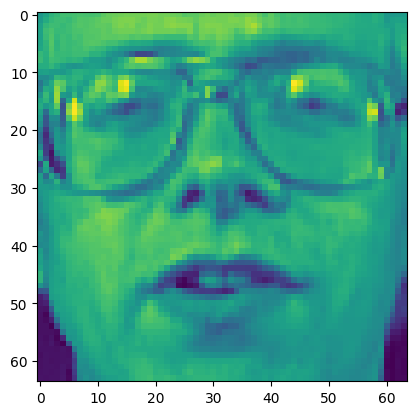

In [ ]:
plt.imshow(test_image)

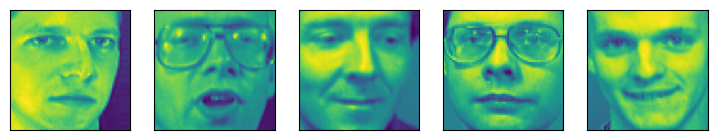

In [ ]:
test_visualize(compare_images)

In [ ]:
image_pairs = []

for image in compare_images:
    image_pairs.append((test_image, image))

image_pairs = np.array(image_pairs)

In [ ]:
score = siamese_model.predict([image_pairs[:, 0, :], image_pairs[:, 1, :]])

1/1 [==============================] - 0s 22ms/step


In [ ]:
print(score)

[[0.35398817]
 [0.53797483]
 [0.0527202 ]
 [0.06707711]
 [0.04304043]]
